# Kerasを利用したAdversarial Examplesの生成(MNIST, FGSM)

必要なライブラリをインポート

In [1]:
from keras.models import load_model
from keras.datasets import mnist
from keras.callbacks import TensorBoard

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
plt.ion()

# 自作ライブラリ
from adversarial  import AdvImg # Adversarial Examples生成
import model_make as mm # 攻撃対象のCNNを作成

Using TensorFlow backend.


## データセット(MNIST)を読み込む

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1) / 255. # [0, 255] -> [0, 1]に正規化
x_test = x_test.reshape(-1, 28, 28, 1) / 255.

## 攻撃対象のCNNの読み込み or 学習

In [3]:
# 攻撃対象のCNNの保存先 or 読み込み先
model_path = Path("..", "model_dir")
model_path.mkdir(exist_ok=True)
model_path /= "CNN.h5"

# 学習済みのCNNがあればロード、なければ作成
if model_path.exists():
    model = load_model(str(model_path))
else:
    model = mm.CNN(input_shape=(28, 28, 1)) # MNIST用
    tb = TensorBoard(log_dir="logs")
    model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
    model.fit(x=x_train, y=y_train, epochs=5, validation_data=(x_test, y_test), callbacks=[tb])
    model.save(str(model_path))

# 4枚のAdversarial Examplesを作ってみる

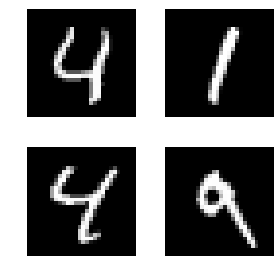

In [12]:
target_img = x_test[4:8].reshape(-1, 28, 28, 1)
target_label = y_test[4:8]

fig = plt.figure(figsize=(4, 4))
for i, img in enumerate(target_img):
    plt.subplot(2, 2, i+1)
    plt.imshow(np.squeeze(img), cmap='gray')
    plt.axis('off')

plt.tight_layout()

## Adversarial Examplesの生成

In [17]:
advgen = AdvImg(model)
advgen.fgsm(x=target_img, y=target_label, epsilon=0.01, num_iter=30)

True label:  [4 1 4 9]
Initial pred: [4 1 4 9]
セッション読み込み完了
5, Pred: [4 1 4 9]
10, Pred: [4 1 4 9]
15, Pred: [4 1 8 4]
20, Pred: [4 8 8 4]
25, Pred: [4 8 8 4]
30, Pred: [4 8 8 4]


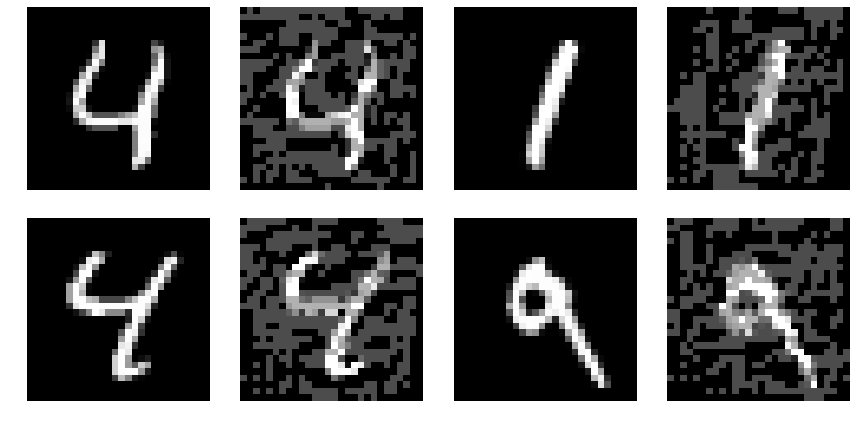

In [18]:
fig = plt.figure(figsize=(12, 6))
for i, (orig_img, adv_img) in enumerate(zip(target_img, advgen.x_adv)):
    plt.subplot(2, 4, 2*i+1)
    plt.imshow(np.squeeze(orig_img), cmap='gray')
    plt.axis('off')
    plt.subplot(2, 4, 2*i+2)
    plt.imshow(np.squeeze(adv_img), cmap='gray')
    plt.axis('off')

plt.tight_layout()

## イテレーションごとの各正解ラベルに対する推論確率の推移をプロット

In [19]:
pred_probs = np.array([[p[j][tl] for j, tl in enumerate(target_label)] for i, p in enumerate(advgen.preds)]).T
# 解説：下と同じことをやってる 出力 shape = (4, 30)

# bb = []
# for i, p in enumerate(advgen.preds):
#     aa = []
#     for j, tl in enumerate(target_label):
#         aa.append(p[j][tl])
#     bb.append(aa)
# cc = np.array(bb).T
# cc.shape

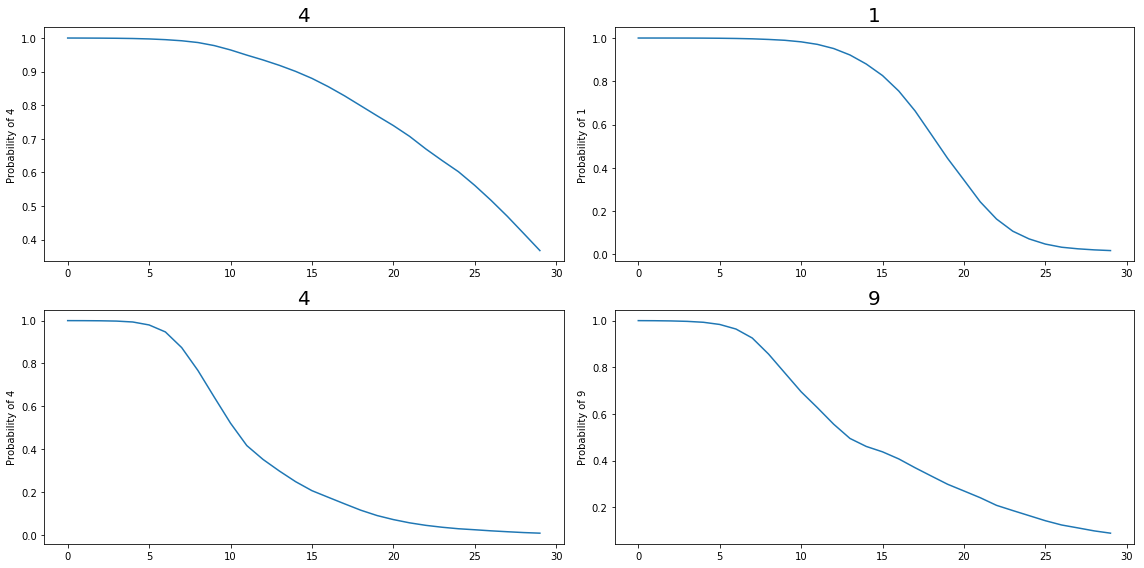

In [23]:
plt.figure(figsize=(16, 8))
for i, (p, tl) in enumerate(zip(pred_probs, target_label)):
    plt.subplot(2, 2, i+1)
    plt.plot(p)
    plt.title(tl, fontsize=20)
    plt.ylabel(f"Probability of {tl}")
plt.tight_layout()